In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.filterwarnings("ignore", "external/local_xla/xla/")
warnings.filterwarnings("ignore", "TensorRT")
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import numpy as np
import crc
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn import preprocessing
import pickle

2024-02-26 17:41:48.570284: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 17:41:49.995018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 17:41:49.995128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 17:41:50.115796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 17:41:50.183200: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Colours
og_hex, rc_hex = crc.get_colours(2)

In [3]:
MODE          = '2,2'
MODE_tag      = MODE.replace(',', '_')
COMPONENTS    = ['full', 'A', 'phi']
COMPONENT     = 'A'
COMPONENT_tag = COMPONENTS.index(COMPONENT)
# N             = 3
# N             = 2
N             = 0
N_test        = 1
SPIN          = False
SPIN_tag      = "spin" if SPIN else "spinless"
CONDITIONING  = True

32/32 [==============================] - 0s 1ms/step
A)    ind: 17.000   | mse: 0.000     | mismatch: 10^(-5.685)
phi)  ind: 44.000 | mse: 11.313 | mismatch: 10^(-5.257)
full) ind: 0.000| mismatch: 10^(-1.755)


/rds/projects/p/pratteng-gwastro/conda/envs/igwn-py311-2023/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/rds/projects/p/pratteng-gwastro/conda/envs/igwn-py311-2023/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


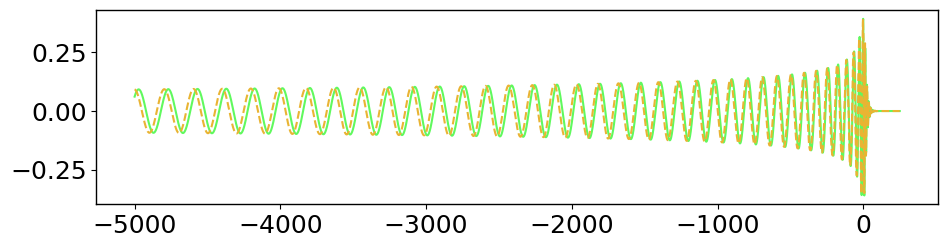

In [13]:
crc.p3peline_spinless('2,2')

In [65]:
time = np.load(f'../datasets_new/{SPIN_tag}/time.npy')
_, time_indexes_A  , B_A  , _ = crc.load_bits(MODE, 'A'  , N)
_, time_indexes_phi, B_phi, _ = crc.load_bits(MODE, 'phi', N)
T_A, T_phi                    = time[time_indexes_A], time[time_indexes_phi]

In [19]:
with open(f"../models/scaler_spinless_2_2_A.pickle", 'rb') as infile:
    yscaler_A = pickle.load(infile)
with open(f"../models/scaler_spinless_2_2_phi.pickle", 'rb') as infile:
    yscaler_phi = pickle.load(infile)

In [20]:
model_A   = tf.keras.saving.load_model(f'../models/spinless_{MODE_tag}_A.keras')
model_phi = tf.keras.saving.load_model(f'../models/spinless_{MODE_tag}_phi.keras')

In [49]:
waveforms_test              = crc.add_A_phi(crc.load_waveforms(MODE, N_test, spin=False, aligned=True))
full_test, A_test, phi_test = crc.reformat(waveforms_test, 'q')
full_test, A_test, phi_test = full_test, A_test, phi_test

In [50]:
x_data_A  , y_data_A   = crc.load_dataset_spinless(MODE, 'A'  , N_test, time_indexes_A)
x_data_phi, y_data_phi = crc.load_dataset_spinless(MODE, 'phi', N_test, time_indexes_phi)
q_data_A               = x_data_A[:, :1]
q_data_phi             = x_data_phi[:, :1]
q_data                 = x_data_A[:, :1]

In [51]:
if not CONDITIONING:
    predict_A   = model_A.predict(q_data)
    predict_phi = model_phi.predict(q_data)

elif CONDITIONING:
    predict_A   = yscaler_A.inverse_transform(model_A.predict(q_data))
    predict_phi = yscaler_phi.inverse_transform(model_phi.predict(q_data))

32/32 [==============================] - 0s 1ms/step


In [52]:
# define function to sort a wf into chronological order

In [53]:
reconstructed_A = np.zeros((len(A_test), len(time)))
reconstructed_phi = np.zeros_like(reconstructed_A)
reconstructed_full = np.zeros_like(reconstructed_phi, dtype=np.complex128)

for i, q in zip([i for i in range(len(A_test))], [float(q) for q in A_test]): # need to make sorted arrays first
    
    h_A                    = predict_A[i]
    Ih_A                   = crc.EI_h(h_A, B_A, time_indexes_A)
    reconstructed_A[i]    += Ih_A

    h_phi                  = predict_phi[i]
    Ih_phi                 = crc.EI_h(h_phi, B_phi, time_indexes_phi)
    reconstructed_phi[i]  += Ih_phi

    reconstructed_full[i] += Ih_A * np.exp(1j * Ih_phi)

In [55]:
mse_A, mse_phi = (np.square(predict_A - y_data_A)).mean(axis=1), (np.square(predict_phi - y_data_phi)).mean(axis=1)
ind_A, ind_phi = np.where(np.max(mse_A) == mse_A)[0][0], np.where(np.max(mse_phi) == mse_phi)[0][0]
mm_A, mm_phi   = crc.mismatch(reconstructed_A[ind_A], A_test[list(A_test.keys())[ind_A]]), crc.mismatch(reconstructed_phi[ind_phi], phi_test[list(phi_test.keys())[ind_phi]])
print(f'A)   ind: {ind_A:.3f} | mse: {mse_A[ind_A]:.3f} | mismatch: 10^({np.log10(mm_A):.3f})')
print(f'phi) ind: {ind_phi:.3f} | mse: {mse_phi[ind_phi]:.3f} | mismatch: 10^({np.log10(mm_phi):.3f})')

A)   ind: 17.000 | mse: 0.000 | mismatch: 10^(-5.685)
phi) ind: 44.000 | mse: 11.313 | mismatch: 10^(-5.257)


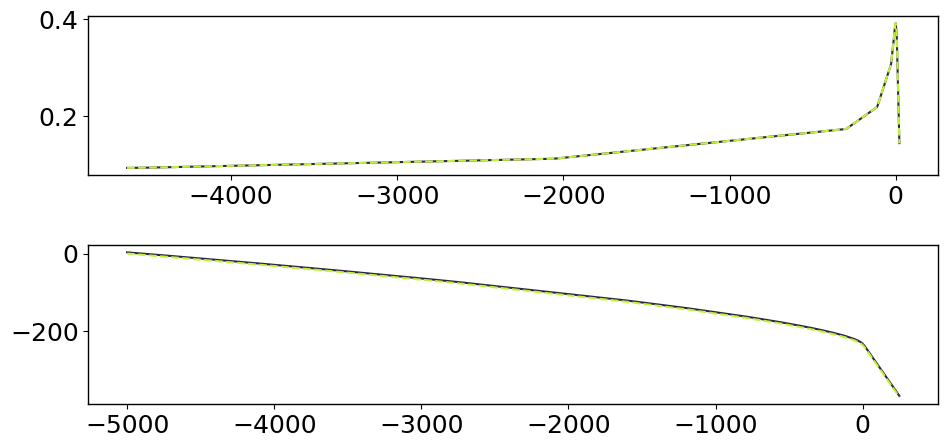

In [78]:
# pre-interpolation: m
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot([a[0] for a in sorted(zip(T_A, y_data_A[ind_A]))],
            [a[1] for a in sorted(zip(T_A,y_data_A[ind_A]))], 
            color=og_hex, label = "Original", zorder=0)
axs[0].plot([a[0] for a in sorted(zip(T_A, predict_A[ind_A]))], 
            [a[1] for a in sorted(zip(T_A, predict_A[ind_A]))], 
            label = "Neural Network", color=rc_hex, linestyle="dashed", zorder=1)
axs[1].plot([a[0] for a in sorted(zip(T_phi, y_data_phi[ind_phi]))],
            [a[1] for a in sorted(zip(T_phi, y_data_phi[ind_phi]))],
            color=og_hex, label = "Original", zorder=0)
axs[1].plot([a[0] for a in sorted(zip(T_phi, predict_phi[ind_phi]))], 
            [a[1] for a in sorted(zip(T_phi, predict_phi[ind_phi]))], 
            label = "Neural Network", color=rc_hex, linestyle="dashed", zorder=1)
fig.tight_layout()

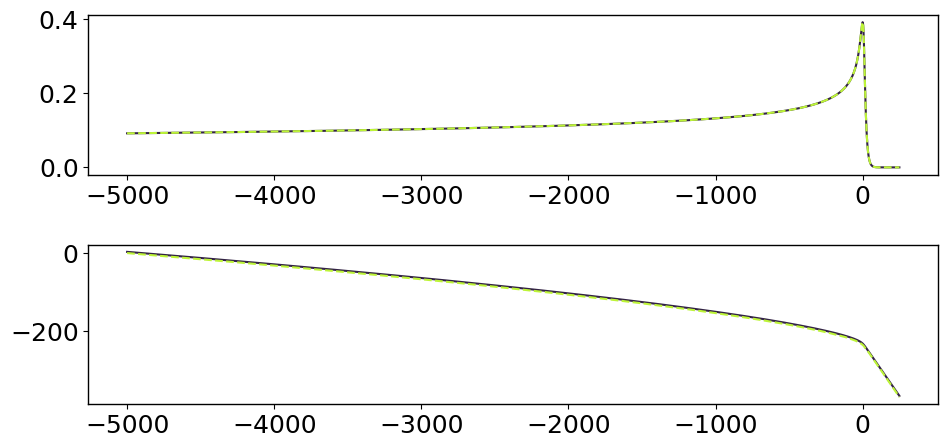

In [60]:
# post-interpolation: M
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(time, crc.matrix_basis(A_test)[ind_A],
            color=og_hex, label = "Original", zorder=0)
axs[0].plot(time, reconstructed_A[ind_A], 
            label = "Neural Network", color=rc_hex, linestyle="dashed", zorder=1)
axs[1].plot(time, crc.matrix_basis(phi_test)[ind_phi],
            color=og_hex, label = "Original", zorder=0)
axs[1].plot(time, reconstructed_phi[ind_phi],
            label = "Neural Network", color=rc_hex, linestyle="dashed", zorder=1)
fig.tight_layout()

In [61]:
ind_ = [ind_A, ind_phi]
ind = ind_[0]

/rds/projects/p/pratteng-gwastro/conda/envs/igwn-py311-2023/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/rds/projects/p/pratteng-gwastro/conda/envs/igwn-py311-2023/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


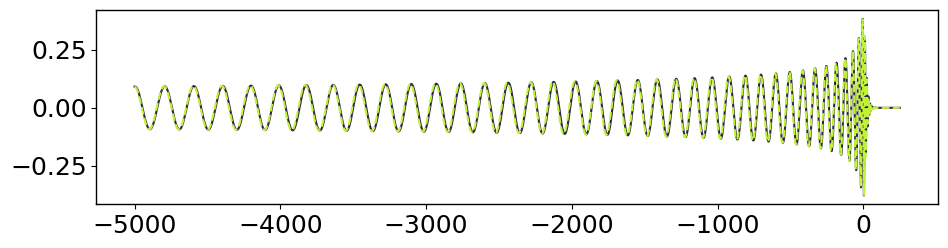

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(time, full_test[list(full_test.keys())[ind]], color=og_hex, label = "Original", zorder=0)
ax.plot(time, reconstructed_full[ind]               , color=rc_hex, label = "Neural Network", linestyle="dashed", zorder=1)
fig.tight_layout()

In [64]:
print(f"full mismatch : 10^({np.log10(np.abs(crc.mismatch(reconstructed_full[ind]  , full_test[list(full_test.keys())[ind]]))):.3f})")

full mismatch : 10^(-2.085)
